# Poster popularity by state

This notebook loads data of poster viewership at the SfN 2016 annual meeting, organized by the states that were affiliated with each poster.

We find that the posters are most popular 

### Import libraries and load data

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

import pandas as pd

In [2]:
# Load data
df = pd.DataFrame.from_csv('./posterviewers_by_state.csv')
key_N = 'Number of people'

# 1. Summarize data by state

In [3]:
# 0. Count number of posters from each state
# Calculate mean poster popularity
states = df['State'].unique()
dict_state_counts = {'State':states,'count':np.zeros(len(states),dtype=int),'popularity':np.zeros(len(states))}
for i, s in enumerate(states):
    dict_state_counts['count'][i] = int(sum(df['State']==s))
    dict_state_counts['popularity'][i] = np.round(np.mean(df[df['State']==s][key_N]),3)
df_counts = pd.DataFrame.from_dict(dict_state_counts)

In [4]:
# Visualize dataframe
# count = total number of posters counted affiliated with that country
# popularity = average number of viewers at a poster affiliated with that country
df_counts.head()

,State,count,popularity
0,TX,126,2.683
1,MA,165,2.309
2,CA,336,2.560
3,CO,18,1.389
4,PA,106,2.462


# 2. Poster popularity vs. prevalence
Across states in the United States, we found a positive correlation between the number of posters from a state and the popularity of those posters.

SpearmanrResult(correlation=0.46154773681508132, pvalue=0.0007415358467146142)


(0.9, 1000)

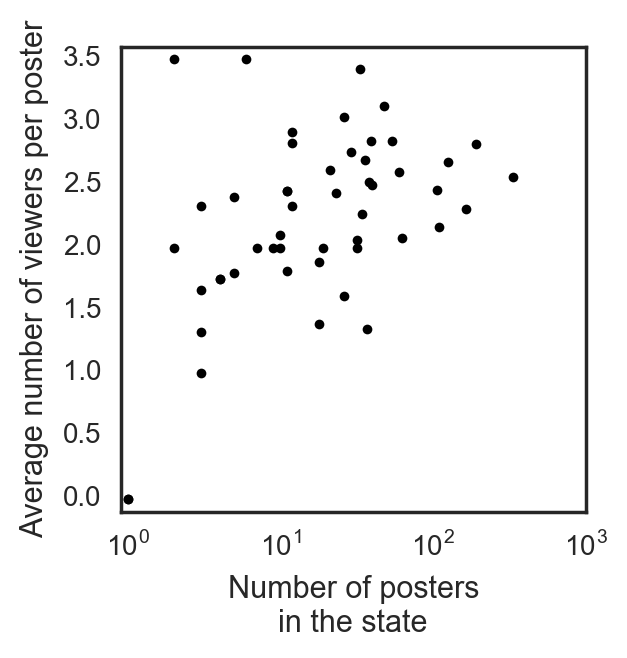

In [5]:
print sp.stats.spearmanr(np.log10(df_counts['count']),df_counts['popularity'])
plt.figure(figsize=(3,3))
plt.semilogx(df_counts['count'],df_counts['popularity'],'k.')
plt.xlabel('Number of posters\nin the state')
plt.ylabel('Average number of viewers per poster')
plt.ylim((-.1,3.6))
plt.xlim((.9,1000))

# 3. Permutation tests: difference in popularity across states
In this code, we test if the relative popularity / unpopularity observed for any state is outside what is expected by chance

Here, the most popular and least popular states are defined by a nonparametric statiscal test between the number of viewers at posters from their country, compared to posters from all other countries.

In [6]:
# Simulate randomized data
Nperm = 100
N_posters = len(df)
rand_statepop = np.zeros((Nperm,len(states)),dtype=np.ndarray)
rand_statepopmean = np.zeros((Nperm,len(states)))
for i in range(Nperm):
    # Random permutation of posters, organized by state
    randperm_viewers = np.random.permutation(df[key_N].values)
    for j, s in enumerate(states):
        rand_statepop[i,j] = randperm_viewers[np.where(df['State']==s)[0]]
        rand_statepopmean[i,j] = np.mean(randperm_viewers[np.where(df['State']==s)[0]])

In [7]:
# True data: Calculate all p-values for the difference between 1 state's popularity and the rest
min_N_posters = 10
states_big = states[np.where(df_counts['count']>=min_N_posters)[0]]
N_big = len(states_big)
t_true_all = np.zeros(N_big)
p_true_all = np.zeros(N_big)
for i, state in enumerate(states_big):
    t_true_all[i], _ = sp.stats.ttest_ind(df[df['State']==state][key_N],df[df['State']!=state][key_N])
    _, p_true_all[i] = sp.stats.mannwhitneyu(df[df['State']==state][key_N],df[df['State']!=state][key_N])
    
pmin_pop = np.min(p_true_all[np.where(t_true_all>0)[0]])
pmin_unpop = np.min(p_true_all[np.where(t_true_all<0)[0]])

print 'Most popular state: ', states_big[np.argmax(t_true_all)], '. p=', str(pmin_pop)
print 'Least popular state: ', states_big[np.argmin(t_true_all)], '. p=', str(pmin_unpop)

Most popular state:  MN . p= 0.00300841211498
Least popular state:  CT . p= 0.000190505731694


In [8]:
# Calculate minimum p-values for each permutation

# Calculate all p and t values
t_rand_all = np.zeros((Nperm,N_big))
p_rand_all = np.zeros((Nperm,N_big))
pmin_pop_rand = np.zeros(Nperm)
pmin_unpop_rand = np.zeros(Nperm)
for i in range(Nperm):
    for j, state in enumerate(states_big):
        idx_use = range(len(states_big))
        idx_use.pop(j)
        t_rand_all[i,j], _ = sp.stats.ttest_ind(rand_statepop[i,j],np.hstack(rand_statepop[i,idx_use]))
        _, p_rand_all[i,j] = sp.stats.mannwhitneyu(rand_statepop[i,j],np.hstack(rand_statepop[i,idx_use]))
        
    # Identify the greatest significance of a state being more popular than the rest
    pmin_pop_rand[i] = np.min(p_rand_all[i][np.where(t_rand_all[i]>0)[0]])
    # Identify the greatest significance of a state being less popular than the rest
    pmin_unpop_rand[i] = np.min(p_rand_all[i][np.where(t_rand_all[i]<0)[0]])

In [9]:
# Test if most popular and least popular countries are outside of expectation
print 'Chance of a state being more distinctly popular than Minnesota: '
print sum(i < pmin_pop for i in pmin_pop_rand) / float(len(pmin_pop_rand))
print 'Chance of a state being less distinctly popular than Connecticut: '
print sum(i < pmin_unpop for i in pmin_unpop_rand) / float(len(pmin_unpop_rand))

Chance of a state being more distinctly popular than Minnesota: 
0.11
Chance of a state being less distinctly popular than Connecticut: 
0.01
